### Import Packages:

In [3]:
# import packages
import modin.pandas as md
import pandas as pd
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as wb
import numpy as np
import matplotlib.pyplot as plt
from functions.functions import *
from copy import deepcopy
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import and Clean Data:

In [4]:
# monthly stock file location
file_path = 'data/crsp_monthly_file.csv'

# import and clean data
data = import_clean_data(path=file_path)

# compute avg daily volumes
data = compute_price_volume(df=data)

importing and cleaning data...
computing average daily volumes...


In [5]:
# compute size rankings
data['SIZE'] = data.groupby(['date'])['MKTCAP'].transform(lambda x: pd.qcut(x,2,labels=False)+1)

# compute momentum signal
data = compute_mom_signal(df=data,window=11,lag=1)

# drop any rows for which we don't have a momentum signal
data = data.dropna(how='any',subset=['MOM','RET'])

# only keep stocks that meet a certain liquidity requirement
daily_liquidity_req = 0
data = data[data['ADV'] > daily_liquidity_req]

# select starting date
start_date = '1965-12-31'
data = data[data['date'] > start_date]

# compute quantiles
quantiles = 10
print('computing quantiles...')
data['QTLS'] = data.groupby(['date'])['MOM'].transform(lambda x: pd.qcut(x,quantiles,labels=False)+1)
data['QTLS_adj'] = data.groupby(['date','SIZE'])['MOM'].transform(lambda x: pd.qcut(x,quantiles,labels=False,duplicates='drop')+1)

computing momentum signal (11-month window and 1-month lag)
computing quantiles...


### Compute Portfolios:

In [6]:
# just take the top and bottom quantiles, this speeds up future computations
reduced_data = compute_reduced_dataset(df=data,quantiles=quantiles,top_mktcap=False,no_companies_per_quantile=500,reduce=True)

# compute returns on portfolio that holds the stocks for the next month
holding_periods = compute_holding_periods(df=reduced_data,hold_months=1)

# compute portfolios (before pivoting return streams)
port, portfolio = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods)

# compute size adjusted strategy returns
print('Repeating for size-adjusted portfolios:')
reduced_data_adj = compute_reduced_dataset_adj(df=data,quantiles=quantiles,top_mktcap=False,no_companies_per_quantile=500,reduce=True)
holding_periods_adj = compute_holding_periods_adj(df=reduced_data,hold_months=1)
size_adjusted_strategy = merge_holding_periods_on_returns_adj(data=data,holding_periods=holding_periods_adj,quantiles=quantiles)

reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
Repeating for size-adjusted portfolios:
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...


### Plot Return Streams:

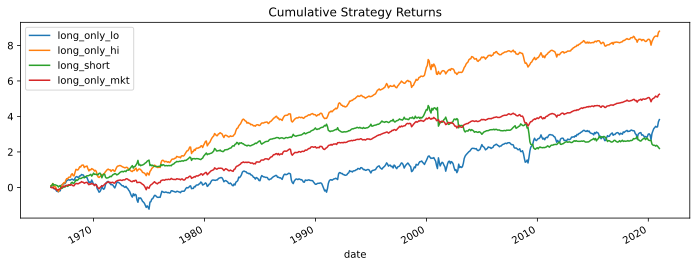

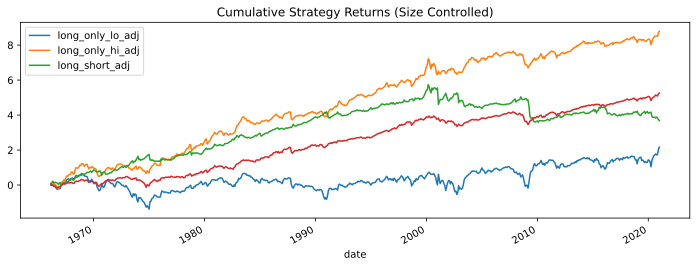

In [7]:
# pivot portfolio returns for plotting
strategy_pivot = port.pivot(index='date', columns='QTLS', values='RET').add_prefix('quantile ').rename(columns={'quantile 1': 'low',f'quantile {int(quantiles)}': 'high'}).fillna(0)

# compute low-beta portfolio less high-beta portfolio returns
strategy_pivot['high-low'] = strategy_pivot.high - strategy_pivot.low

# add value-weighted market returns
mkt = data.drop_duplicates(subset=['date','vwretd']).sort_values(by=['date'])[['date','vwretd']].set_index('date')
mkt['long_only_mkt'] = np.log(1 + mkt).cumsum()
mkt = mkt[mkt.index >= strategy_pivot.index[0]]

# compute strategy cumulative returns
strategy_pivot['long_only_lo'] = np.log(1 + strategy_pivot.low).cumsum()
strategy_pivot['long_only_hi'] = np.log(1 + strategy_pivot.high).cumsum()
strategy_pivot['long_short'] = np.log(1 + (strategy_pivot['high-low'])).cumsum()


# compute plots for each strategy
plt.figure(figsize=(12,4))
strategy_pivot['long_only_lo'].plot()
strategy_pivot['long_only_hi'].plot()
strategy_pivot['long_short'].plot()
mkt['long_only_mkt'].plot()
plt.title('Cumulative Strategy Returns')
plt.legend()
plt.show()

size_adjusted_strategy[['long_only_lo_adj','long_only_hi_adj','long_short_adj']].plot(figsize=(12,4))
mkt['long_only_mkt'].plot()
plt.title('Cumulative Strategy Returns (Size Controlled)')
plt.show()

### Heatmap of Signal Period vs. Lag Time:

importing and cleaning data...
computing average daily volumes...
computing momentum signal (1-month window and 0-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (3-month window and 0-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (6-month window and 0-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (12-month window and 0-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period d

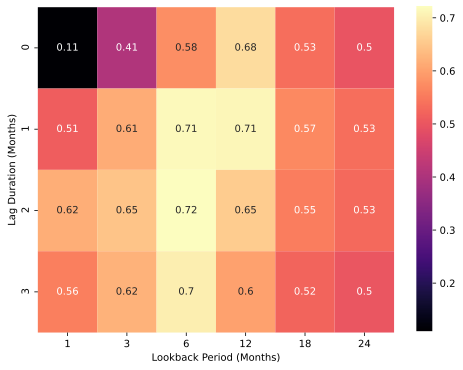

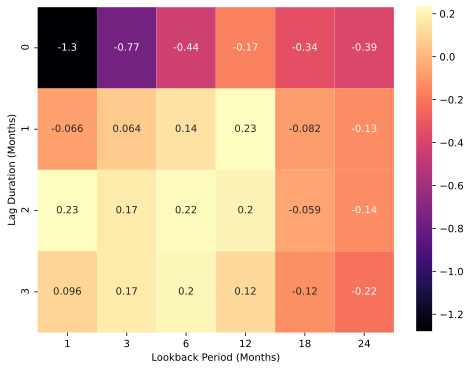

In [8]:
lookbacks = np.array([1,3,6,12,18,24])
lags = np.arange(0,4)

# import and clean data
loop_data = import_clean_data(path=file_path)
# compute avg daily volumes
loop_data = compute_price_volume(df=data)

# storage
long_only_means = np.zeros(shape=(len(lags),len(lookbacks)))
long_only_stdevs = np.zeros(shape=(len(lags),len(lookbacks)))

long_short_means = np.zeros(shape=(len(lags),len(lookbacks)))
long_short_stdevs = np.zeros(shape=(len(lags),len(lookbacks)))

for r, lag_i in enumerate(lags):
    for c, lookback in enumerate(lookbacks):
        # compute momentum signal
        loop = compute_mom_signal(df=loop_data,window=lookback,lag=lag_i)
        # drop any rows for which we don't have a momentum signal
        loop = loop.dropna(how='any',subset=['MOM','RET'])
        # only keep stocks that meet a certain liquidity requirement
        daily_liquidity_req = 0
        loop = loop[loop['ADV'] > daily_liquidity_req]
        # select starting date
        start_date = '1965-12-31'
        loop = loop[loop['date'] > start_date]
        # compute quantiles
        quantiles = 10
        print('computing quantiles...')
        loop['QTLS'] = loop.groupby(['date'])['MOM'].transform(lambda x: pd.qcut(x,quantiles,labels=False,duplicates='drop')+1)
        # just take the top and bottom quantiles, this speeds up future computations
        reduced_data_loop = compute_reduced_dataset(df=loop,quantiles=quantiles,top_mktcap=False,no_companies_per_quantile=500,reduce=True)
        # compute returns on portfolio that holds the stocks for the next month
        holding_periods_loop = compute_holding_periods(df=reduced_data_loop,hold_months=1)
        # also scales quantile portfolio weights so that their Beta relative to the market approximates 1
        port_loop, portfolio_loop = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods_loop)
        # pivot portfolio returns for plotting
        pivoted = port_loop.pivot(index='date', columns='QTLS', values='RET').add_prefix('quantile ').rename(columns={'quantile 1': 'low',f'quantile {int(quantiles)}': 'high'}).fillna(0)
        # compute low-beta portfolio less high-beta portfolio returns
        pivoted['high-low'] = pivoted.high - pivoted.low
        # store items in list
        lo_mean = pivoted.high.mean()
        lo_std = pivoted.high.std()
        long_only_means[r,c] = lo_mean
        long_only_stdevs[r,c] = lo_std
        ls_mean = pivoted['high-low'].mean()
        ls_std = pivoted['high-low'].std()
        long_short_means[r,c] = ls_mean
        long_short_stdevs[r,c] = ls_std 

long_only_sharpes = pd.DataFrame((long_only_means*12)/(long_only_stdevs*np.sqrt(12)),index=lags,columns=lookbacks)
long_short_sharpes = pd.DataFrame((long_short_means*12)/(long_short_stdevs*np.sqrt(12)),index=lags,columns=lookbacks)

# output results
plt.figure(figsize=(8,6))
sns.heatmap(data=long_only_sharpes,cmap='magma',annot=True)
plt.xlabel('Lookback Period (Months)')
plt.ylabel('Lag Duration (Months)')
plt.show()
plt.figure(figsize=(8,6))
sns.heatmap(data=long_short_sharpes,cmap='magma',annot=True)
plt.xlabel('Lookback Period (Months)')
plt.ylabel('Lag Duration (Months)')
plt.show()

importing and cleaning data...
computing average daily volumes...
computing momentum signal (11-month window and -5-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (11-month window and -4-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (11-month window and -3-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding period data...
computing momentum signal (11-month window and -2-month lag)
computing quantiles...
reducing data to just top and bottom quantiles, taking all companies...
computing one-month holding periods...
merging return and holding p

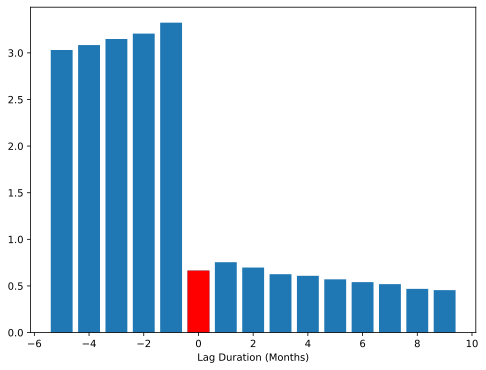

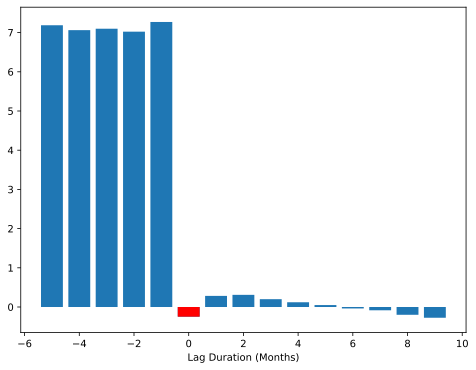

In [9]:
lags = np.arange(-5,10)

# import and clean data
loop_data = import_clean_data(path=file_path)
# compute avg daily volumes
loop_data = compute_price_volume(df=data)

# storage
long_only_means = []
long_only_stdevs = []

long_short_means = []
long_short_stdevs = []

for r, lag_i in enumerate(lags):
    # compute momentum signal
    loop = compute_mom_signal(df=loop_data,window=11,lag=lag_i)
    # drop any rows for which we don't have a momentum signal
    loop = loop.dropna(how='any',subset=['MOM','RET'])
    # only keep stocks that meet a certain liquidity requirement
    daily_liquidity_req = 0
    loop = loop[loop['ADV'] > daily_liquidity_req]
    # select starting date
    start_date = '1965-12-31'
    loop = loop[loop['date'] > start_date]
    # compute quantiles
    quantiles = 10
    print('computing quantiles...')
    loop['QTLS'] = loop.groupby(['date'])['MOM'].transform(lambda x: pd.qcut(x,quantiles,labels=False,duplicates='drop')+1)
    # just take the top and bottom quantiles, this speeds up future computations
    reduced_data_loop = compute_reduced_dataset(df=loop,quantiles=quantiles,top_mktcap=False,no_companies_per_quantile=500,reduce=True)
    # compute returns on portfolio that holds the stocks for the next month
    holding_periods_loop = compute_holding_periods(df=reduced_data_loop,hold_months=1)
    # also scales quantile portfolio weights so that their Beta relative to the market approximates 1
    port_loop, portfolio_loop = merge_holding_periods_on_returns(data=data,holding_periods=holding_periods_loop)
    # pivot portfolio returns for plotting
    pivoted = port_loop.pivot(index='date', columns='QTLS', values='RET').add_prefix('quantile ').rename(columns={'quantile 1': 'low',f'quantile {int(quantiles)}': 'high'}).fillna(0)
    # compute low-beta portfolio less high-beta portfolio returns
    pivoted['high-low'] = pivoted.high - pivoted.low
    # store items in list
    lo_mean = pivoted.high.mean()
    lo_std = pivoted.high.std()
    long_only_means.append(lo_mean)
    long_only_stdevs.append(lo_std)
    ls_mean = pivoted['high-low'].mean()
    ls_std = pivoted['high-low'].std()
    long_short_means.append(ls_mean)
    long_short_stdevs.append(ls_std)
    
# output results
plotarray = ((np.array(long_only_means)*12)/(np.array(long_only_stdevs)*np.sqrt(12)))
plt.figure(figsize=(8,6))
plt.bar(x=lags,height=plotarray)
plt.bar(x=0,height=plotarray[lags == 0],color='r')
plt.xlabel('Lag Duration (Months)')
plt.show()

plotarray = ((np.array(long_short_means)*12)/(np.array(long_short_stdevs)*np.sqrt(12)))
plt.figure(figsize=(8,6))
plt.bar(x=lags,height=plotarray)
plt.bar(x=0,height=plotarray[lags == 0],color='r')
plt.xlabel('Lag Duration (Months)')
plt.show()

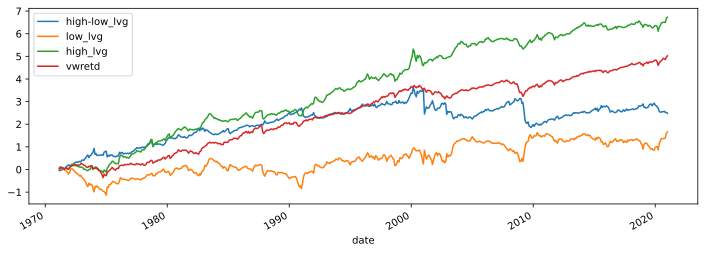

In [10]:
# lever/delever long/short ends of portfolio to make portfolio market neutral
levers = ['low','high']
i = 0
for each in levers:
    # set up rolling regression
    Y = strategy_pivot[each]
    X = sm.add_constant(mkt['vwretd'])
    est = RollingOLS(Y,X,window=60,min_nobs=60,expanding=True).fit()
    leverage_betas = est.params.shift(1)[['vwretd']]
    if each == 'high':
        strategy_pivot[f'{each}_lvg'] = strategy_pivot[each].values + (1 - est.params['vwretd'].shift(1).values) * mkt['vwretd']
    else:
        strategy_pivot[f'{each}_lvg'] = strategy_pivot[each].values + (1 - est.params['vwretd'].shift(1).values) * mkt['vwretd']
strategy_pivot['high-low_lvg'] = strategy_pivot.high_lvg - strategy_pivot.low_lvg

# plot cumulative returns
np.log(1+strategy_pivot['high-low_lvg']).cumsum().plot(figsize=(12,4))
np.log(1+strategy_pivot['low_lvg']).cumsum().plot(figsize=(12,4))
np.log(1+strategy_pivot['high_lvg']).cumsum().plot(figsize=(12,4))
np.log(1+mkt.vwretd[60:]).cumsum().plot()
plt.legend()
plt.show()

In [11]:
# regression summary of long-short strategy
Y = strategy_pivot['high-low_lvg']
X = sm.add_constant(mkt['vwretd'])
est = sm.OLS(Y,X,missing='drop',).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:           high-low_lvg   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.419
Date:                Sun, 05 Dec 2021   Prob (F-statistic):              0.234
Time:                        18:42:43   Log-Likelihood:                 752.25
No. Observations:                 599   AIC:                            -1501.
Df Residuals:                     597   BIC:                            -1492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.003      2.678      0.0

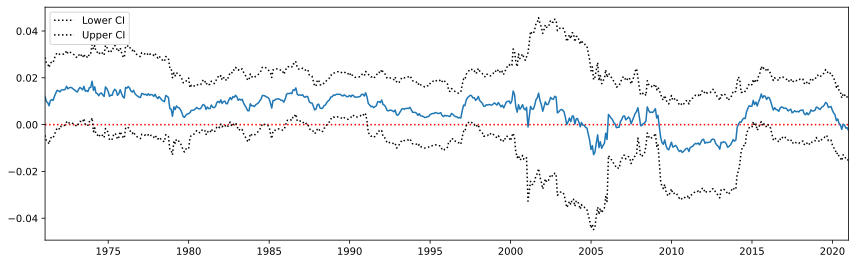

In [12]:
# rolling alpha
Y = strategy_pivot['high-low']
X = sm.add_constant(mkt['vwretd'])
est = RollingOLS(Y,X,window=60,min_nobs=60,missing='drop').fit()
est.plot_recursive_coefficient(variables=['const'],alpha=0.05,figsize=(12,4))
plt.hlines(0,est.params.dropna(how='all').index[0],est.params.dropna(how='all').index[-1],colors='r',linestyles=':')
plt.title('')
plt.show()

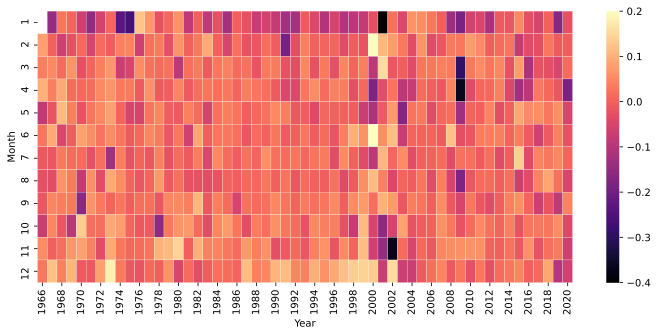

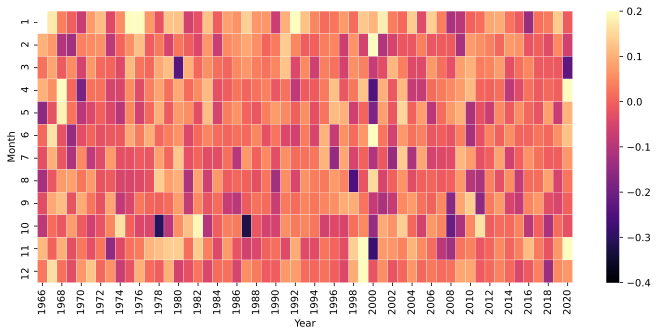

In [13]:
def plot_seasonality(df, ret):
    df = pd.DataFrame(df).reset_index()
    df['Year'] = pd.DatetimeIndex(df['date']).year
    df['Month'] = pd.DatetimeIndex(df['date']).month
    df = df.pivot(index='Month', columns='Year', values=ret)
    plt.figure(figsize=(12,5))
    ax = sns.heatmap(df,linewidths=.2,cmap='magma',vmin=-0.4,vmax=0.2)
    plt.show()

plot_seasonality(strategy_pivot['high-low'].dropna(how='any'),'high-low')
plot_seasonality(strategy_pivot['high'].dropna(how='any'),'high')

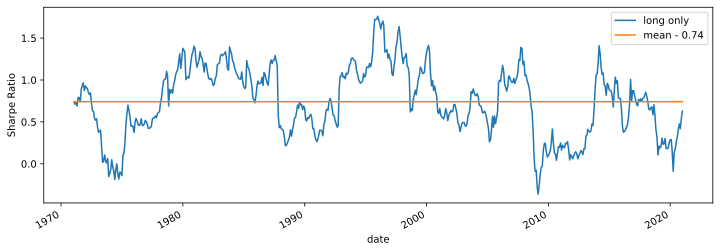

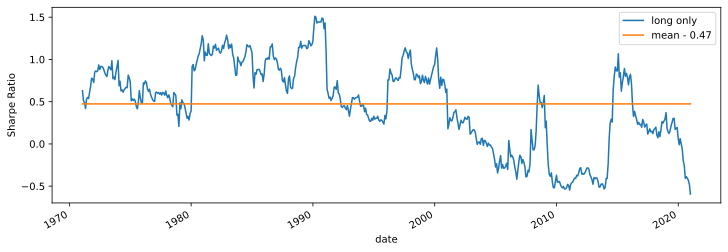

In [14]:
# 5 Year Rolling Sharpe Ratio for Long Only and Long/Short Configuration
configs = ['high','high-low']

for each in configs:
    means = (strategy_pivot[[each]].rolling(window=60,min_periods=60).mean() * 12).dropna()
    stds = (strategy_pivot[[each]].rolling(window=60,min_periods=60).std() * np.sqrt(12)).dropna()
    sharpes = means/stds
    sharpes['average'] = np.full(sharpes.shape,fill_value=sharpes.mean())
    sharpes.plot(figsize=(12,4))
    plt.ylabel('Sharpe Ratio')
    plt.legend(['long only',f'mean - {round(sharpes.average.mean(),ndigits=2)}'])
    plt.show()